# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [1]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection

## Calculating wakeup glucose

This function will only suit for pnp3 because it involves adding adjusted glucose from a file outside LabData. 

In [37]:
def calculate_wakeup_glucose_pnp3(time_between = [5,7], study_ids=[3,49]):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am 
    firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgm_adj['Day'] = cgm_adj.index.date
    cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename(
                                'wakeup_glucose'))
    
    return wakeup_glucose

In [38]:
wakeup_glucose = calculate_wakeup_glucose_pnp3()

In [ ]:
wakeup_glucose.head()

## Wakeup glucose variability distribution

In [ ]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [ ]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [ ]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

In [ ]:
morn_gluc_distr.sample(10)

In [ ]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [ ]:
morn_gluc_distr['interquartile_range'].mean()

### Todo: I should look at this values before and after the intervention and compare changes for the two diets. 

In [ ]:
wakeup_glucose.shape

For how many days did people wear CGM sensor?

In [ ]:
count = wakeup_glucose.groupby('RegistrationCode')['Day'].count()

In [ ]:
count.plot.hist()

Let's take all people with at least 50 days of  connections.

In [ ]:
rc_to_keep = count[count >= 50].index

In [ ]:
len(rc_to_keep)

We have 207 people in total.

## Leave only those people with more than 50 days of connections

In [39]:
def more_than_x_connection_days(wakeup_glucose_df, x=50):
    wakeup_glucose_df = wakeup_glucose_df.reset_index()
    count = wakeup_glucose_df.groupby('RegistrationCode')['Day'].count()
    rc_to_keep = count[count >= 50].index
    # wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]
    wakeup_glucose_df = wakeup_glucose_df[wakeup_glucose_df['RegistrationCode'].isin(rc_to_keep)].drop(columns='hour')
    return wakeup_glucose_df

In [40]:
wakeup_glucose = more_than_x_connection_days(wakeup_glucose)

In [9]:
wakeup_glucose.head()

,RegistrationCode,Day,wakeup_glucose
0,111527,2017-11-08,103.071429
1,111527,2017-11-10,98.071429
2,111527,2017-11-11,101.321429
3,111527,2017-11-12,107.071429
4,111527,2017-11-13,106.071429


In [10]:
wakeup_glucose.shape

(25432, 3)

## Dietary features from the day before

In [34]:
def prepare_data_for_corr(wg_df, nutrient_list, study_ids=[3,49], min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    :param wg_df : wakeup_glucose DataFrame
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, totaldaylog, on=['RegistrationCode', 'Day'])
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'd' 
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']
        # Change dtype to datetime for merge with wg_df        
        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, splitlog, on=['RegistrationCode', 'Day'])
        data_for_corr = data_for_corr.fillna(0)
        
    data_for_corr = data_for_corr.drop(columns='Day')
    return data_for_corr

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [353]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

In [55]:
data_corr_total = prepare_data_for_corr(wakeup_glucose, nutrient_list, study_ids=[3,49], 
                                        min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18])

In [38]:

data_corr_split = prepare_data_for_corr(wakeup_glucose, nutrient_list, study_ids=[3,49], 
                                        min_cal_per_day=1000, how='split_diet', daysplithours=[6,12,18])

In [39]:
data_corr_total.head()

,RegistrationCode,wakeup_glucose,totaldietaryfiber_g,energy_kcal,carbohydrate_g,protein_g,totallipid_g,weight,sugarstotal_g,sodium_mg,caffeine_mg,carbs/lipids,caloric%carbs,caloric%fat
0,111527,103.071429,12.664168,1919.71453,231.320475,73.624292,79.052895,2350.14,6.538000,2000.838539,558.00,2.926148,0.481989,0.370616
1,111527,98.071429,11.263018,1517.15022,194.751503,50.789459,58.201139,2135.04,6.313964,1691.501330,562.50,3.346180,0.513467,0.345259
2,111527,101.321429,13.546815,2087.21548,265.900131,79.098687,73.305995,2037.62,5.414400,2289.811585,328.50,3.627263,0.509579,0.316093
3,111527,107.071429,16.807222,1317.76292,160.317880,48.809778,44.786748,1488.03,25.698000,1862.517280,328.50,3.579583,0.486636,0.305883
4,111527,106.071429,12.343034,1871.10702,231.655018,78.098902,70.233976,1950.01,83.697100,3063.713740,305.22,3.298333,0.495226,0.337824


In [ ]:
data_corr_total.loc['132178'].plot.scatter(x='sodium_mg', y='wakeup_glucose')

## Correlation table

I could also do the same for the night CV. Make function calculate_night_stats(). 

In [40]:
def corr_wg_dietdaybefore(data_corr, method='spearman'):
    
    """Calculate correlations between the wakeup glucose (WG) and the diet the day before.
    :param method: String 'spearman' or 'pearson'
    
    """
    from scipy.stats import pearsonr, spearmanr
    from statsmodels.stats.multitest import fdrcorrection
    
    means = data_corr.groupby('RegistrationCode').mean()
    std = data_corr.groupby('RegistrationCode').std()
    data_corr = data_corr.set_index('RegistrationCode')
    # standartization of the values into z scores
    for rc in data_corr.index.unique():
        data_corr.loc[rc] = (data_corr.loc[rc] - means.loc[rc])/std.loc[rc]
    data_corr = round(data_corr, 4)
    statistics_df = pd.DataFrame(means.stack(level=-1))
    # I don't want to calculate correlation between wg and itself
#     slice_column_names = statistics_df.index.levels[-1][statistics_df.index.levels[-1] != 'wakeup_glucose']
#     statistics_df = statistics_df.loc[(slice(None), slice_column_names), :]
    
    if method == 'spearman':
        
        statistics_df['rho'] = 0
        statistics_df['pvalue'] = 0
        statistics_df = statistics_df.drop(columns=0)

        for rc in data_corr.index.unique():
#             for column in data_corr.drop(columns='wakeup_glucose').columns:
            for column in data_corr.columns:
                spearman = spearmanr(data_corr.loc[rc]['wakeup_glucose'], data_corr.loc[rc][column])
                statistics_df.loc[(rc, column), 'rho'] = spearman[0]
                statistics_df.loc[(rc, column), 'pvalue'] = spearman[1]
                
    elif method == 'pearson':

        statistics_df['rho'] = 0
        statistics_df['pvalue'] = 0
        statistics_df = statistics_df.drop(columns=0)

        for rc in data_corr.index.unique():
            for column in data_corr.drop(columns='wakeup_glucose').columns:
                pearson = pearsonr(data_corr.loc[rc]['wakeup_glucose'], data_corr.loc[rc][column])
                statistics_df.loc[(rc, column), 'rho'] = pearson[0]
                statistics_df.loc[(rc, column), 'pvalue'] = pearson[1]
    
    values = {'rho': 0, 'pvalue': 1}
    statistics_df = statistics_df.fillna(value=values)
    # Add FDR corrected pvalues
    pvalues = statistics_df['pvalue']
    pvalues_corrected = pd.Series(fdrcorrection(pvalues)[1])
    pvalues_corrected.index = statistics_df.index
    statistics_df['pvalue_corrected'] = pvalues_corrected
    
    return statistics_df
    

In [64]:
corr_table_total = corr_wg_dietdaybefore(data_corr_total)

In [42]:
corr_table_split = corr_wg_dietdaybefore(data_corr_split)

In [ ]:
corr_table_split.isnull().sum()

In [57]:
corr_table_total.head()

rho    pvalue  pvalue_corrected
RegistrationCode                                                          
111527           wakeup_glucose       1.000000  0.000000          0.000000
                 totaldietaryfiber_g  0.014553  0.867456          0.960239
                 energy_kcal         -0.138335  0.110932          0.355152
                 carbohydrate_g       0.137657  0.112711          0.357249
                 protein_g            0.005120  0.953182          0.984650

In [29]:
slice_column_names = corr_table_total.index.levels[-1][corr_table_total.index.levels[-1] != 'wakeup_glucose']
corr_table_total = corr_table_total.loc[(slice(None), slice_column_names), :]

Normality testing method

In [ ]:
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import shapiro
# # seed the random number generator
# seed(1)
# # normality test
# for column in data.columns:
#     stat, p = shapiro(data.loc['300747'][column])
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret
#     alpha = 0.05
#     if p > alpha:
#         print(column, ': Sample looks Gaussian (fail to reject H0)')
#     else:
#         print(column, ': Sample does not look Gaussian (reject H0)')

In PNP3 patients probably avoided alcohol due to the diet. I should exclude this feature from the correlation analysis.

In [ ]:
# spearmancorr = data_corr_total.corr(method='spearman')
# spearmancorr

In [ ]:
# sb.heatmap(pearsoncorr, 
#             xticklabels=pearsoncorr.columns,
#             yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
#             annot=True,
#             linewidth=0.5)

In [ ]:
# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues

# calculate_pvalues(data.loc['111527']) 

In [ ]:
corr_table_split[(corr_table_split['pvalue_corrected'] < 0.05)]

In [59]:
corr_table_total[(corr_table_total['pvalue_corrected'] < 0.05)].shape

(347, 3)

In [60]:
corr_table_total[(corr_table_total['pvalue'] < 0.05)].shape

(614, 3)

In [72]:
corr_table_total.head()

rho    pvalue  pvalue_corrected  \
RegistrationCode                                                        
111527           wakeup_glucose       1.0  0.000000          0.000000   
                 totaldietaryfiber_g  NaN  0.867456          0.960239   
                 energy_kcal          NaN  0.110932          0.355152   
                 carbohydrate_g       NaN  0.112711          0.357249   
                 protein_g            NaN  0.953182          0.984650   

                                      significant  
RegistrationCode                                   
111527           wakeup_glucose                 1  
                 totaldietaryfiber_g            0  
                 energy_kcal                    0  
                 carbohydrate_g                 0  
                 protein_g                      0

## Visualize correlations

In [76]:
def plot_corr_heatmap(corr_table, savefig=False, filename=None):
    """Handles the table with correlations and pvalues and draws a heatmap with significant coefficients"""
        
    import plotly.graph_objects as go
    # Unsignificant correlations replace with None for not having them in the graph
    corr_table['significant'] = 0
    corr_table.loc[(corr_table['pvalue_corrected'] < 0.05),'significant'] = 1
    corr_table.loc[(corr_table['significant'] == 0), 'rho'] = None
    # Delete rows with wg correlations to itself
    slice_column_names = corr_table.index.levels[-1][corr_table.index.levels[-1] != 'wakeup_glucose']
    corr_table = corr_table.loc[(slice(None), slice_column_names), :]
    # Prepare data for visualization
    signif_corr = corr_table.unstack(level=-1)['rho']
    signif_corr.columns.name = None
    rc_list = signif_corr.index
    rc_list = ['rc' + item for item in rc_list]
    diet_feat_list = signif_corr.columns
    sign_corr_list = signif_corr.values.tolist()

    # Build the heatmap
    fig = go.Figure(data=go.Heatmap(
                       z=sign_corr_list,
                       x=diet_feat_list,
                       y=rc_list,
                       hoverongaps = False))
    fig.update_layout(
        title={
            'text': "Personalized correlations between the wakeup glucose and dietary features from the day before",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Dietary features",
        yaxis_title="Registration Code"
        )
    fig.show()
    
    if savefig:
        path = '/home/elming/Cache/plotly_figures/' + filename + '.html'
        fig.write_html(path)


In [77]:
corr_table_total = corr_wg_dietdaybefore(data_corr_total)

In [73]:
corr_table_split = corr_wg_dietdaybefore(data_corr_split)

In [78]:
plot_corr_heatmap(corr_table_total, savefig=True, filename='corr_total_diet_pnp3_fdr')

In [67]:
plot_corr_heatmap(corr_table_total, savefig=True, filename='corr_total_diet_pnp3_nonfdr')

In [75]:
plot_corr_heatmap(corr_table_split, savefig=True, filename='corr_split_diet_pnp3_nonfdr')

## Correlations for the total cohort (not personalized)

In [84]:
data_corr_total

,wakeup_glucose,totaldietaryfiber_g,energy_kcal,carbohydrate_g,protein_g,totallipid_g,weight,sugarstotal_g,sodium_mg,caffeine_mg,carbs/lipids,caloric%carbs,caloric%fat
RegistrationCode,,,,,,,,,,,,,
111527,0.349300,0.627075,1.522302,3.553935,-0.272886,-0.697373,3.041030,-0.165274,-0.094478,3.242574,2.656941,2.846758,-2.157391
111527,-0.291937,0.218174,-0.041475,2.648198,-1.456848,-1.628582,2.321464,-0.189381,-0.619724,3.292399,3.243500,3.201142,-2.451168
111527,0.124867,0.884660,2.172966,4.410401,0.010956,-0.954021,1.995568,-0.286179,0.396189,0.701493,3.636022,3.157370,-2.789091
111527,0.862289,1.836151,-0.816003,1.795348,-1.559492,-2.227648,0.157043,1.896439,-0.329344,0.701493,3.569438,2.899077,-2.907388
111527,0.734042,0.533358,1.333484,3.562221,-0.040882,-1.091213,1.702489,8.137434,1.710252,0.443731,3.176683,2.995777,-2.537308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,-0.025140,-0.677929,0.919645,-0.058501,0.891051,1.026852,0.167137,-1.020914,-0.644736,0.023433,-0.360759,-0.353348,0.392124
997735,-0.305759,-0.455263,-1.870747,-1.331291,-1.542364,-0.907916,-0.772911,-0.913752,-0.572964,-0.249895,-0.871495,-1.235918,1.423999
997735,-0.084218,-0.060993,-0.326095,-0.795384,-0.090174,0.218678,-1.042250,-0.698685,-0.871065,-2.055397,-0.649366,-0.846629,0.814102


In [81]:
means = data_corr_total.groupby('RegistrationCode').mean()
std = data_corr_total.groupby('RegistrationCode').std()
data_corr_total = data_corr_total.set_index('RegistrationCode')
# standartization of the values into z scores
for rc in data_corr_total.index.unique():
    data_corr_total.loc[rc] = (data_corr_total.loc[rc] - means.loc[rc])/std.loc[rc]

In [85]:
pvalues = []
for column in data_corr_total.columns:
    spearman = spearmanr(data_corr_total['wakeup_glucose'], data_corr_total[column])
    print(column, spearman[0], spearman[1])
    pvalues.append(spearman[1])

wakeup_glucose 1.0 0.0
totaldietaryfiber_g 0.025153543602175196 0.0001506042885098631
energy_kcal 0.05064626782846472 2.259237872194263e-14
carbohydrate_g 0.053649393368153254 6.050425997442778e-16
protein_g 0.04164994011957497 3.442014093475484e-10
totallipid_g 0.029579569468083954 8.302042163818213e-06
weight 0.06738938069037735 2.87034514782844e-24
sugarstotal_g 0.021271354499279763 0.0013507739747861227
sodium_mg 0.02383681065476446 0.00032864009826438784
caffeine_mg 0.022523303644745578 0.0006896860617502874
carbs/lipids 0.015132034076714807 0.02261803613276978
caloric%carbs 0.019710298147534444 0.0029807579071119174
caloric%fat -0.011348531130609359 0.08731177016512383


## Calculating stats of the night

### Explore sleep logging in pnp3

I can take the nights from midnight to 6 am unless a person logged food during that time. Also let's check how many people and days do we have sleep log for in PNP3.

In [8]:
from LabData.DataLoaders.SleepLoader import SleepLoader
sl = SleepLoader()
sleep = sl.get_data(study_ids=[3,49]).df
sleep_filtered = sl.filter_for_night_sleep(sleep)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [10]:
sleep_filtered['Duration'] = (sleep_filtered.wakeup_time - sleep_filtered.sleep_time) / pd.Timedelta(hours=1)

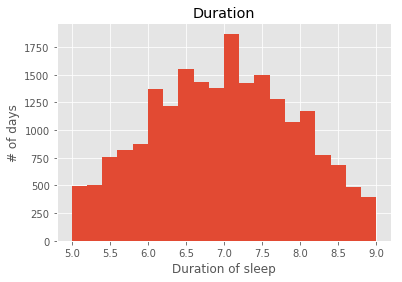

In [12]:
sleep_filtered.hist(bins=20)
plt.xlabel('Duration of sleep')
plt.ylabel('# of days');

In [13]:
sleep_filtered['sleep_time_plot'] = (sleep_filtered['sleep_time'] - sleep_filtered['sleep_time'].dt.normalize()) / pd.Timedelta(hours=1)

sleep_filtered['wakeup_time_plot'] = (sleep_filtered['wakeup_time'] - sleep_filtered['wakeup_time'].dt.normalize()) / pd.Timedelta(hours=1)

In [14]:
mask = sleep_filtered['sleep_time_plot'] >= 21

sleep_filtered.loc[mask, 'sleep_time_plot'] = sleep_filtered[mask]['sleep_time_plot'] - 24

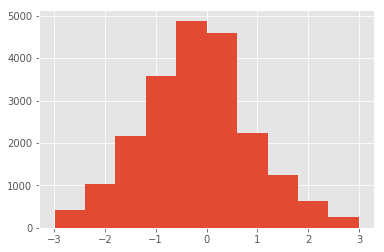

In [16]:
sleep_filtered['sleep_time_plot'].hist()

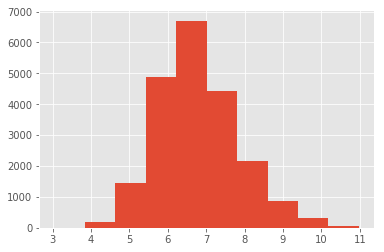

In [17]:
sleep_filtered['wakeup_time_plot'].hist()

In [24]:
sleep_filtered['Day'] = sleep_filtered['wakeup_time'].dt.date
sleep_filtered = sleep_filtered.set_index('Day', append=True)

In [33]:
sleep_filtered.shape

(21066, 5)

In [22]:
wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429

In [32]:
wakeup_glucose.shape

(25432, 3)

In [34]:
pd.merge(wakeup_glucose, sleep_filtered, on=['RegistrationCode', 'Day'])

,RegistrationCode,Day,wakeup_glucose,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot
0,111527,2017-11-08,103.071429,2017-11-07 22:55:06+02:00,2017-11-08 05:50:40+02:00,6.926111,-1.081667,5.844444
1,111527,2017-11-10,98.071429,2017-11-09 23:15:47+02:00,2017-11-10 06:02:34+02:00,6.779722,-0.736944,6.042778
2,111527,2017-11-11,101.321429,2017-11-11 01:18:50+02:00,2017-11-11 09:12:20+02:00,7.891667,1.313889,9.205556
3,111527,2017-11-12,107.071429,2017-11-11 23:07:37+02:00,2017-11-12 05:30:30+02:00,6.381389,-0.873056,5.508333
4,111527,2017-11-13,106.071429,2017-11-12 23:40:48+02:00,2017-11-13 05:30:43+02:00,5.831944,-0.320000,5.511944
...,...,...,...,...,...,...,...,...
12889,997735,2019-07-04,110.722222,2019-07-04 00:02:54+03:00,2019-07-04 07:00:02+03:00,6.952222,0.048333,7.000556
12890,997735,2019-07-05,92.972222,2019-07-04 23:57:26+03:00,2019-07-05 08:05:01+03:00,8.126389,-0.042778,8.083611
12891,997735,2019-07-06,105.972222,2019-07-06 00:37:11+03:00,2019-07-06 09:34:01+03:00,8.947222,0.619722,9.566944
12892,997735,2019-07-07,101.472222,2019-07-06 23:43:39+03:00,2019-07-07 07:17:01+03:00,7.556111,-0.272500,7.283611


More than a half of the people actually have their sleep time logged, but I will anyway first try to take midnight till 6 am as a sleep time for everyone to generate stats.

### Stats of the night

In [53]:
def add_gluc_adj_pnp3(study_ids=[3,49]):    

    """"""
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    # adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc[['GlucoseAdj50N13_Mm', 'Date', 'ConnectionID']], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    return cgm_adj

In [54]:
cgm_adj = add_gluc_adj_pnp3()

In [259]:
def filter_by_time(df, start, end):
    
    """
    The function filters the cgm entries between certain hours of the day. 
    The output is a dataframe containing the entries between start and end hour of each day.
    :param df: CGM DataFrame
    :param start: string of a type 'hh:mm'
    :param end: string of a type 'hh:mm'
    :return: filtered DataFrame with an index set to 'RegistrationCode', 'Day' and 'Time'
    """

    df = df.set_index('Date')
    filtered_df = df.between_time(start, end)
    pd.options.mode.chained_assignment = None  # to avoid the warning message about chained assignments
    filtered_df['Day'] = filtered_df.index.date
    # Make it a separate function
    # From the night cgm adjusted I need to remove nights with less than 20 observations
#     count = filtered_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
#     rc_days_to_keep = count[count >= 20].index
#     filtered_df = filtered_df.set_index(['RegistrationCode', 'Day'])
#     filtered_df = filtered_df.loc[rc_days_to_keep]
    
    return filtered_df

In [142]:
night_cgm_adj = filter_by_time(cgm_adj, '00:00', '06:00')

In [256]:
night_cgm_adj.head()

ConnectionID  GlucoseValue  PPGR  hour  GlucoseAdj
RegistrationCode Day                                                          
111527           2017-11-08         1926         100.0  0.00     0   98.571429
                 2017-11-08         1926          97.0  0.00     0   95.571429
                 2017-11-08         1926          96.0  0.00     0   94.571429
                 2017-11-08         1926          93.0  1.75     0   91.571429
                 2017-11-08         1926          90.0  9.25     1   88.571429

In [100]:
def count_stats(cgm_df):
    
    def q50(x):
        return x.quantile(0.5)

    def q75(x):
        return x.quantile(0.75)

    def q90(x):
        return x.quantile(0.9)

    def q95(x):
        return x.quantile(0.95)

    f = {'GlucoseAdj': ['mean', 'std', q50, q75, q90, q95]}
    
    stats = cgm_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].agg(f)
    stats.columns = stats.columns.droplevel()
    stats['CV'] = stats['std'] / stats['mean']
    return stats

In [168]:
night_cgm_stats = count_stats(night_cgm_adj)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [169]:
night_cgm_stats.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08   96.529762   6.188904   95.571429  100.571429   
                 2017-11-09   99.696429   6.641847   99.071429  103.571429   
                 2017-11-10   92.321429   5.350742   93.071429   96.821429   
                 2017-11-11  111.196429  11.293755  109.571429  118.321429   
                 2017-11-12   93.071429   2.570738   93.071429   94.571429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08  102.571429  105.121429  0.064114  
                 2017-11-09  108.071429  110.421429  0.066621  
                 2017-11-10   99.271429   99.571429  0.057958  
                 2017-11-11  125.771429  133.521429  0.101566  
                 2017-11-12   95.571429   97.271429  0.027621

In [ ]:
night_cgm_stats = night_cgm_stats.reset_index('Day')
night_cgm_stats['Day'] = pd.to_datetime(night_cgm_stats['Day'])
night_cgm_stats.head()

In [312]:
night_cgm_stats_wakeup = pd.merge(wakeup_glucose, night_cgm_stats, on=['RegistrationCode', 'Day'])

In [322]:
night_cgm_stats_wakeup.head()

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
0,111527,2017-11-08,103.071429,96.529762,6.188904,95.571429,100.571429,102.571429,105.121429,0.064114
1,111527,2017-11-10,98.071429,92.321429,5.350742,93.071429,96.821429,99.271429,99.571429,0.057958
2,111527,2017-11-11,101.321429,111.196429,11.293755,109.571429,118.321429,125.771429,133.521429,0.101566
3,111527,2017-11-12,107.071429,93.071429,2.570738,93.071429,94.571429,95.571429,97.271429,0.027621
4,111527,2017-11-13,106.071429,89.696429,2.542038,89.571429,90.571429,92.571429,93.421429,0.028340


In [315]:
# Transforming all the table into Z-scores
means = night_cgm_stats_wakeup.drop(columns='Day').groupby('RegistrationCode').mean()
std = night_cgm_stats_wakeup.drop(columns='Day').groupby('RegistrationCode').std()
night_cgm_stats_wakeupz = night_cgm_stats_wakeup.set_index('RegistrationCode')

night_cgm_stats_wakeupz = night_cgm_stats_wakeupz.drop(columns='Day')
# standartization of the values into z scores
for rc in night_cgm_stats_wakeupz.index.unique():
    night_cgm_stats_wakeupz.loc[rc] = (night_cgm_stats_wakeupz.loc[rc] - means.loc[rc])/std.loc[rc]

In [323]:
night_cgm_stats_wakeupz.shape

(23672, 8)

In [324]:
night_cgm_stats_wakeup.shape

(23672, 10)

### Correlation between the wakeup glucose and CV of the night

In [209]:
#Z-transformed wakeup glucose and CV
spearman = spearmanr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.1172923918251988, pvalue=2.7636586106814287e-73)


In [325]:
#Not transformed CV but transformed wakeup glucose
spearman = spearmanr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeupz['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.10423996578331701, pvalue=3.46552335223662e-58)


In [193]:
pearson = pearsonr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeup['wakeup_glucose'])
print(pearson)

(-0.15788244125999729, 5.901224284518917e-132)


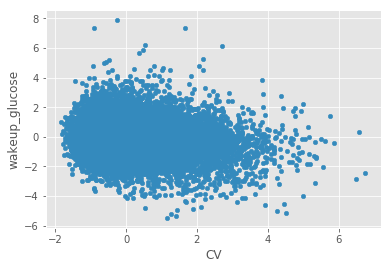

In [195]:
night_cgm_stats_wakeup.plot.scatter(x='CV', y='wakeup_glucose')

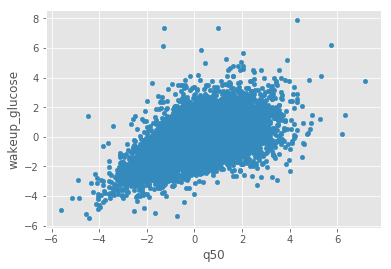

In [210]:
night_cgm_stats_wakeup.plot.scatter(x='q50', y='wakeup_glucose')

Study individual correlations

In [250]:
night_cgm_stats_wakeup.head()

,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
RegistrationCode,,,,,,,,
111527,0.297220,-0.172687,-0.069862,-0.177058,-0.119000,-0.263344,-0.247947,-0.023088
111527,-0.337392,-0.717476,-0.263594,-0.516275,-0.498079,-0.535849,-0.651463,-0.174821
111527,0.075106,1.725981,1.110068,1.722559,1.675304,1.652444,1.816890,0.899994
111527,0.804910,-0.620385,-0.906161,-0.516275,-0.725526,-0.841384,-0.818686,-0.922532
111527,0.677987,-1.057294,-0.912795,-0.991179,-1.129876,-1.089115,-1.098602,-0.904803


I need to create a table with unique registration codes as index and two columns with 0: rho and pvalue

In [213]:
unique_rc_list = night_cgm_stats_wakeup.index.unique()

ind_corr_df = pd.DataFrame(index=unique_rc_list, columns=['rho','pvalue'])

In [218]:
for rc in night_cgm_stats_wakeup.index.unique():
    spearman = spearmanr(night_cgm_stats_wakeup.loc[rc]['wakeup_glucose'], night_cgm_stats_wakeup.loc[rc]['CV'])
    ind_corr_df.loc[rc, 'rho'] = spearman[0]
    ind_corr_df.loc[rc, 'pvalue'] = spearman[1]

In [222]:
pvalues = ind_corr_df['pvalue']
pvalues_corrected = pd.Series(fdrcorrection(pvalues)[1])
pvalues_corrected.index = ind_corr_df.index

In [224]:
ind_corr_df['pvalues_corrected'] = pvalues_corrected

In [227]:
sign_corr = ind_corr_df[ind_corr_df['pvalues_corrected'] < 0.05]

In [229]:
sign_corr.head()

,rho,pvalue,pvalues_corrected
RegistrationCode,,,
12752,-0.325173,0.00470038,0.0270272
136529,-0.303164,0.00084674,0.00834643
148574,-0.259643,0.00615898,0.03269
215130,-0.222153,0.00436999,0.0258454
242185,-0.436184,1.53682e-07,3.18122e-05


In [238]:
sign_corr = sign_corr.reset_index()

In [451]:
sign_corr.shape

(50, 4)

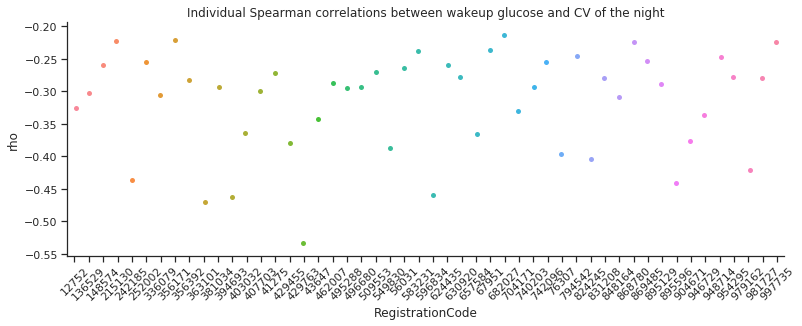

In [249]:
import seaborn as sns
sns.set(style="ticks")
g = sns.catplot(x='RegistrationCode', y="rho", data=sign_corr)
g.fig.set_figheight(4)
g.fig.set_figwidth(14)
g.set_xticklabels(rotation=45)
plt.title('Individual Spearman correlations between wakeup glucose and CV of the night')
plt.show()

Let's see how does the scatterplot look for the person with the highest negative correlation

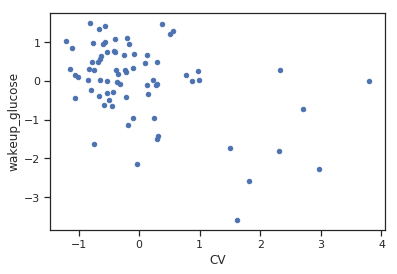

In [284]:
night_cgm_stats_wakeup.loc['12752'].plot.scatter(x='CV', y='wakeup_glucose')

Do correlations between CV and the diet day before

## CV of the night split into 0-3 am and 3-6 am

In [260]:
night_cgm_1 = filter_by_time(cgm_adj, '00:00', '03:00')
night_cgm_2 = filter_by_time(cgm_adj, '03:00', '06:00')

In [261]:
night_cgm_1.head()

,RegistrationCode,ConnectionID,GlucoseValue,PPGR,hour,GlucoseAdj,Day
Date,,,,,,,
2017-11-08 00:12:00,111527,1926,100.0,0.00,0,98.571429,2017-11-08
2017-11-08 00:27:00,111527,1926,97.0,0.00,0,95.571429,2017-11-08
2017-11-08 00:42:00,111527,1926,96.0,0.00,0,94.571429,2017-11-08
2017-11-08 00:57:00,111527,1926,93.0,1.75,0,91.571429,2017-11-08
2017-11-08 01:12:00,111527,1926,90.0,9.25,1,88.571429,2017-11-08


In [266]:
def check_for_complete_data(df):
    """Leaves only those RCs and days where there is complete cgm data for desired period"""
    
    count = df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
    rc_days_to_keep = count[count >= 12].index
    df = df.set_index(['RegistrationCode', 'Day'])
    df = df.loc[rc_days_to_keep]
    return df

In [268]:
night_cgm_1 = check_for_complete_data(night_cgm_1)
night_cgm_2 = check_for_complete_data(night_cgm_2)

In [269]:
night_stats_1 = count_stats(night_cgm_1)
night_stats_2 = count_stats(night_cgm_2)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [270]:
night_stats_1.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08   93.321429   4.223850   94.071429   96.071429   
                 2017-11-09  102.321429   7.098335  102.571429  105.821429   
                 2017-11-10   90.404762   4.152400   90.071429   93.821429   
                 2017-11-11  118.988095  10.672465  119.071429  123.071429   
                 2017-11-12   92.071429   2.576114   91.571429   92.821429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08   98.471429   98.571429  0.045261  
                 2017-11-09  110.471429  112.371429  0.069373  
                 2017-11-10   94.571429   95.921429  0.045931  
                 2017-11-11  133.871429  135.471429  0.089694  
                 2017-11-12   95.371429   96.471429  0.027980

In [271]:
night_stats_1 = night_stats_1.reset_index('Day')
night_stats_1['Day'] = pd.to_datetime(night_stats_1['Day'])
night_stats_1_wakeup = pd.merge(wakeup_glucose, night_stats_1, on=['RegistrationCode', 'Day'])

In [272]:
night_stats_2 = night_stats_2.reset_index('Day')
night_stats_2['Day'] = pd.to_datetime(night_stats_2['Day'])
night_stats_2_wakeup = pd.merge(wakeup_glucose, night_stats_2, on=['RegistrationCode', 'Day'])

In [273]:
night_stats_1_wakeup.head()

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
0,111527,2017-11-08,103.071429,93.321429,4.223850,94.071429,96.071429,98.471429,98.571429,0.045261
1,111527,2017-11-10,98.071429,90.404762,4.152400,90.071429,93.821429,94.571429,95.921429,0.045931
2,111527,2017-11-11,101.321429,118.988095,10.672465,119.071429,123.071429,133.871429,135.471429,0.089694
3,111527,2017-11-12,107.071429,92.071429,2.576114,91.571429,92.821429,95.371429,96.471429,0.027980
4,111527,2017-11-13,106.071429,88.404762,0.834847,88.571429,88.821429,89.571429,89.571429,0.009443


In [274]:
def standardize_df(df):
    '''Turn numerical values to Z-scores'''
    # Transforming all the table into Z-scores
    means = df.drop(columns='Day').groupby('RegistrationCode').mean()
    std = df.drop(columns='Day').groupby('RegistrationCode').std()
    df = df.set_index('RegistrationCode')

    df = df.drop(columns='Day')
    # standartization of the values into z scores
    for rc in df.index.unique():
        df.loc[rc] = (df.loc[rc] - means.loc[rc])/std.loc[rc]
    return df

In [277]:
night_stats_1_wakeup = standardize_df(night_stats_1_wakeup)
night_stats_2_wakeup = standardize_df(night_stats_2_wakeup)

In [278]:
spearman = spearmanr(night_stats_1_wakeup['CV'], night_stats_1_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.09644704371715299, pvalue=6.917380887365568e-45)


In [279]:
spearman = spearmanr(night_stats_2_wakeup['CV'], night_stats_2_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.04428602302841213, pvalue=6.2901844517916465e-12)


In [280]:
pearson = pearsonr(night_stats_1_wakeup['CV'], night_stats_1_wakeup['wakeup_glucose'])
print(pearson)

(-0.11976540818600545, 2.0848586648101754e-68)


In [281]:
pearson = pearsonr(night_stats_2_wakeup['CV'], night_stats_2_wakeup['wakeup_glucose'])
print(pearson)

(-0.08362098187264952, 1.3257621922369289e-38)


## Relation between wakeup glucose and CV of the day before (7 am to midnight) and evening only (6 pm to midnight)

In [293]:
day_cgm_total = filter_by_time(cgm_adj, '07:00', '23:59')
evening_cgm = filter_by_time(cgm_adj, '18:00', '23:59')

In [294]:
evening_cgm.sample(5)

,RegistrationCode,ConnectionID,GlucoseValue,PPGR,hour,GlucoseAdj,Day
Date,,,,,,,
2019-02-03 20:11:00,590916,4875,131.0,28.750,20,138.818182,2019-02-03
2019-11-07 19:55:00,868780,6081,91.0,0.000,19,89.000000,2019-11-07
2019-06-02 19:51:00,246043,5681,83.0,3.875,19,76.125000,2019-06-02
2018-04-08 18:59:00,631485,2857,91.0,25.125,18,92.333333,2018-04-08
2018-02-25 21:55:00,225207,2484,111.0,20.000,21,105.375000,2018-02-25


In [295]:
def check_for_complete_data(df, numb_ts=1):
    """Leaves only those RCs and days where there is complete cgm data for desired period"""
    
    count = df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
    rc_days_to_keep = count[count >= numb_ts].index
    df = df.set_index(['RegistrationCode', 'Day'])
    df = df.loc[rc_days_to_keep]
    return df

In [296]:
day_cgm_total = check_for_complete_data(day_cgm_total, numb_ts=64)
evening_cgm = check_for_complete_data(evening_cgm, numb_ts=20)

In [297]:
day_cgm_stats = count_stats(day_cgm_total )
evening_stats = count_stats(evening_cgm)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [298]:
day_cgm_stats.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08  116.527311  20.315007  113.571429  128.571429   
                 2017-11-09  112.347548  25.847936  103.571429  119.571429   
                 2017-11-10  114.424370  23.704817  112.071429  123.571429   
                 2017-11-11  111.889610  14.878130  109.071429  117.571429   
                 2017-11-12  112.439076  27.327699  104.071429  130.571429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08  146.571429  153.171429  0.174337  
                 2017-11-09  133.971429  174.571429  0.230071  
                 2017-11-10  141.371429  163.871429  0.207166  
                 2017-11-11  130.071429  142.821429  0.132972  
                 2017-11-12  151.371429  159.171429  0.243044

In [299]:
day_cgm_stats = day_cgm_stats.reset_index('Day')
day_cgm_stats['Day'] = pd.to_datetime(day_cgm_stats['Day'])
day_cgm_stats['Day'] = day_cgm_stats['Day'] + datetime.timedelta(days=1)
day_cgm_stats_wakeup = pd.merge(wakeup_glucose, day_cgm_stats, on=['RegistrationCode', 'Day'])

In [300]:
evening_stats = evening_stats.reset_index('Day')
evening_stats['Day'] = pd.to_datetime(evening_stats['Day'])
evening_stats['Day'] = evening_stats['Day'] + datetime.timedelta(days=1)
evening_stats_wakeup = pd.merge(wakeup_glucose, evening_stats, on=['RegistrationCode', 'Day'])

In [304]:
day_cgm_stats_wakeup.head()

,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
RegistrationCode,,,,,,,,
111527,-0.290612,0.799383,2.405655,-0.298565,0.510549,0.410040,2.653169,2.436699
111527,0.112428,1.214772,1.909071,1.546036,1.117485,1.121992,1.864808,1.802793
111527,0.825499,0.707790,-0.136166,0.895000,0.207081,0.034822,0.313874,-0.250531
111527,0.701486,0.817689,2.748531,-0.190060,2.179624,2.084090,1.518519,2.795734
111527,0.174434,0.614736,1.766133,0.460976,1.686488,1.237444,0.829624,1.803939


In [274]:
def standardize_df(df):
    '''Turn numerical values to Z-scores'''
    # Transforming all the table into Z-scores
    means = df.drop(columns='Day').groupby('RegistrationCode').mean()
    std = df.drop(columns='Day').groupby('RegistrationCode').std()
    df = df.set_index('RegistrationCode')

    df = df.drop(columns='Day')
    # standartization of the values into z scores
    for rc in df.index.unique():
        df.loc[rc] = (df.loc[rc] - means.loc[rc])/std.loc[rc]
    return df

In [302]:
day_cgm_stats_wakeup = standardize_df(day_cgm_stats_wakeup)

KeyError: "None of ['RegistrationCode'] are in the columns"

In [303]:
evening_stats_wakeup = standardize_df(evening_stats_wakeup)

In [307]:
spearman = spearmanr(day_cgm_stats_wakeup['CV'], day_cgm_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.03890395468201828, pvalue=3.5106303497549454e-06)


In [306]:
spearman = spearmanr(evening_stats_wakeup['CV'], evening_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.051072120917598586, pvalue=9.683276347762358e-13)


## CGM plot study on an example

I want to understand how is it possible that the wakeup glucose is negatively correlated with the CV of the night. For that let's take a person that has high correlation and plot his daily CGMs: one with low CV and another one with high CV

In [445]:
night_cgm_stats_wakeup[(night_cgm_stats_wakeup['CV'] > 0.2) & (night_cgm_stats_wakeup['RegistrationCode'] == '394693')]

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
8009,394693,2018-11-16,73.00,82.583333,16.826265,75.0,84.0,111.3,116.55,0.203749
8021,394693,2018-12-01,58.85,66.600000,13.667480,62.6,71.6,79.6,93.60,0.205217


In [466]:
night_cgm_stats_wakeup[(night_cgm_stats_wakeup['CV'] < 0.1) & (night_cgm_stats_wakeup['RegistrationCode'] == '407703')]

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
8315,407703,2018-10-15,92.500000,73.416667,5.182887,74.000000,76.500000,79.400000,80.850000,0.070596
8316,407703,2018-10-16,86.250000,94.083333,9.188446,92.000000,97.250000,105.900000,113.100000,0.097663
8317,407703,2018-10-17,94.500000,98.458333,5.291331,97.500000,101.750000,105.700000,106.850000,0.053742
8318,407703,2018-10-18,89.750000,96.750000,7.847736,94.000000,106.000000,107.000000,107.000000,0.081114
8319,407703,2018-10-22,88.250000,84.250000,4.589686,85.000000,86.500000,89.700000,90.850000,0.054477
...,...,...,...,...,...,...,...,...,...,...
8451,407703,2019-04-25,89.250000,85.541667,4.596588,85.000000,87.500000,91.400000,92.000000,0.053735
8452,407703,2019-04-26,90.000000,93.291667,2.595635,93.000000,95.000000,96.000000,96.850000,0.027823
8453,407703,2019-04-27,86.750000,90.208333,4.383558,90.000000,93.250000,95.000000,95.850000,0.048594
8455,407703,2019-11-02,83.535714,90.452381,8.765876,88.285714,92.035714,105.385714,107.985714,0.096911


In [453]:
sign_corr[sign_corr['RegistrationCode'] == '407703']

,RegistrationCode,rho,pvalue,pvalues_corrected
13,407703,-0.299033,0.000285726,0.00422467


In [341]:
def vis_cgm(rc, date):
    import plotly.express as px
    cgm_slice = cgm_adj[(cgm_adj['RegistrationCode'] == rc) & (cgm_adj['Date'].dt.date == date)]
    return px.line(cgm_slice, x="Date", y="GlucoseAdj", title='day CGM')

In [506]:
vis_cgm('954766', datetime.date(2019,4,19))

Now it would be interesting to see the log information of this person and his sleep and wakeup time if available.

In [354]:
log = dll.get_data(study_ids=[3,49]).df
logdf = dll.add_nutrients(log, nutrient_list)
logdf = dll.squeeze_log(logdf)
logdf = logdf.reset_index()

In [499]:
logdf[(logdf['RegistrationCode'] == '111527') & (logdf['Date'].dt.date == datetime.date(2018,1,13))]

,RegistrationCode,Day,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type,alloc
307,111527,2018-01-13,2018-01-13 08:21:04+02:00,81.00,240.01,0.000000,33.6000,1.836000,36.000000,1.956000,2.760000,0.0000,Beverage,0
308,111527,2018-01-13,2018-01-13 09:30:14+02:00,0.00,227.00,2.504832,741.1238,19.557337,489.437215,15.078365,59.192832,0.6384,Meal,0
309,111527,2018-01-13,2018-01-13 12:24:02+02:00,0.00,150.00,1.350000,135.0000,4.500000,103.500000,7.650000,7.950000,0.0000,Snack,0
310,111527,2018-01-13,2018-01-13 17:30:11+02:00,0.00,303.00,1.567488,1365.1344,11.489628,416.835600,42.774756,34.248540,0.0165,Restaurant,0
311,111527,2018-01-13,2018-01-13 18:30:55+02:00,6.72,32.00,1.088000,25.2800,9.491200,171.200000,2.448000,17.920000,16.4800,Snack,0


In [363]:
sleep_filtered = sleep_filtered.reset_index()
sleep_filtered[(sleep_filtered['RegistrationCode'] == '363101') & (sleep_filtered['wakeup_time'].dt.date == datetime.date(2019,4,7))]

,level_0,index,RegistrationCode,Day,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot
7414,7414,7414,363101,2019-04-07,2019-04-07 00:47:53+03:00,2019-04-07 07:32:44+03:00,6.7475,0.798056,7.545556


In [369]:
# CV of 0.04
vis_cgm('363101', datetime.date(2019,3,14))

In [375]:
logdf[(logdf['RegistrationCode'] == '363101') & (logdf['Date'].dt.date == datetime.date(2019,3,14))]

,RegistrationCode,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type
77803,363101,2019-03-14 08:00:26+02:00,0.0,52.000000,2.453000,28.500000,4.123000,106.020000,2.869500,13.967000,0.31070,Snack
77804,363101,2019-03-14 09:39:51+02:00,0.0,126.400002,6.393600,764.334729,10.035520,329.552004,15.702400,44.057601,0.00000,Meal
77805,363101,2019-03-14 13:36:08+02:00,0.0,20.000000,0.840000,62.000000,2.600000,70.200000,1.200000,13.000000,0.00000,Snack
77806,363101,2019-03-14 14:25:19+02:00,0.0,678.000000,24.885085,3044.894460,7.414971,697.161240,78.163839,55.240056,0.27000,Meal
77807,363101,2019-03-14 16:57:30+02:00,0.0,184.000000,5.704000,1.840000,0.220800,106.720000,0.699200,22.742400,18.03200,Snack
77808,363101,2019-03-14 19:20:58+02:00,0.0,65.000000,2.455000,34.810000,1.544400,124.620000,2.759300,22.912400,5.22230,Snack
77809,363101,2019-03-14 21:10:47+02:00,0.0,297.000000,4.142275,595.399000,16.298555,366.402650,26.734617,25.268225,1.67790,Meal
77810,363101,2019-03-14 21:45:41+02:00,0.0,18.000000,0.990000,1.980000,4.140000,69.660000,1.800000,6.300000,0.04878,Meal


In [374]:
sleep_filtered[(sleep_filtered['RegistrationCode'] == '363101') & (sleep_filtered['wakeup_time'].dt.date == datetime.date(2019,3,14))]

,level_0,index,RegistrationCode,Day,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot


In [379]:
# CV of 0.04
vis_cgm('363101', datetime.date(2019,5,13))

In [380]:
logdf[(logdf['RegistrationCode'] == '363101') & (logdf['Date'].dt.date == datetime.date(2019,5,13))]

,RegistrationCode,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type
78127,363101,2019-05-13 08:59:58+03:00,0.00,111.0,5.922535,337.421,3.123424,154.825818,11.87286,18.64305,0.547760,Meal
78128,363101,2019-05-13 12:00:35+03:00,0.00,250.0,0.000000,8.400,0.225000,144.000000,2.07500,33.67500,0.000000,Meal
78129,363101,2019-05-13 14:08:03+03:00,3.55,309.5,0.957000,502.850,14.842450,535.910000,48.57140,46.52210,2.457000,Meal
78130,363101,2019-05-13 17:20:55+03:00,0.00,77.0,2.925000,67.750,7.286000,172.880000,4.74050,23.27600,0.231500,Snack
78131,363101,2019-05-13 21:05:14+03:00,0.00,309.0,5.119000,335.320,16.602800,310.440000,14.41710,26.27010,3.728100,Meal
78132,363101,2019-05-13 22:15:00+03:00,31.20,276.0,0.546480,42.900,6.300000,166.380000,1.98000,25.32000,13.807404,Snack


## Binary data about snacks in the evening

Hypothesis: snacks after 22 are positively associated with night CV and negatively with wakeup glucose the next day

In [383]:
from scipy.stats import pointbiserialr

In [382]:
night_cgm_stats.head()

,Day,mean,std,q50,q75,q90,q95,CV
RegistrationCode,,,,,,,,
111527,2017-11-08,96.529762,6.188904,95.571429,100.571429,102.571429,105.121429,0.064114
111527,2017-11-09,99.696429,6.641847,99.071429,103.571429,108.071429,110.421429,0.066621
111527,2017-11-10,92.321429,5.350742,93.071429,96.821429,99.271429,99.571429,0.057958
111527,2017-11-11,111.196429,11.293755,109.571429,118.321429,125.771429,133.521429,0.101566
111527,2017-11-12,93.071429,2.570738,93.071429,94.571429,95.571429,97.271429,0.027621


In [ ]:
def night_snacks_binary(study_ids=[3,49], ):
    """"""
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, totaldaylog, on=['RegistrationCode', 'Day'])
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'd' 
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']
        # Change dtype to datetime for merge with wg_df        
        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, splitlog, on=['RegistrationCode', 'Day'])
        data_for_corr = data_for_corr.fillna(0)

In [691]:
carbs_cal_per_gram = 4
fat_cal_per_gram = 9
prot_cal_per_gram = 4

log = dll.get_data(study_ids=[3,49]).df
logdf = dll.add_nutrients(log, nutrient_list)
logdf = dll.squeeze_log(logdf)
logdf = logdf.reset_index()
logdf['Day'] = logdf['Date'].dt.date
#Identify days with good log more than min_cal_per_day
totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= 1000]
days_to_keep = totaldaylog.index
logdf = logdf.set_index(['RegistrationCode', 'Day'])
logdf = logdf.loc[days_to_keep]

In [692]:
logdf['alloc'] = 0
logdf.loc[(logdf['Date'].dt.time >= datetime.time(22, 0, 0)), 'alloc'] = 1

15323 rc days from 43613 with snacks after 22 - good

In [693]:
logdf = logdf.reset_index()
snack_binary = logdf.groupby(['RegistrationCode', 'Day', 'alloc']).sum()

In [694]:
snack_binary = snack_binary.drop(columns=['caffeine_mg', 'weight', 'sodium_mg', 'protein_g', 'sugarstotal_g', 'totaldietaryfiber_g'])
snack_binary.head()

totallipid_g  energy_kcal  carbohydrate_g
RegistrationCode Day        alloc                                           
111527           2017-10-06 0         75.270531  1531.051492      135.737278
                            1          3.925000    97.500000       13.550000
                 2017-10-07 0         68.119205  1168.492650       97.676125
                            1          0.050000     2.500000        0.000000
                 2017-10-08 0         53.919700  1169.040000      116.313900

In [695]:
snack_binary['caloric%carbs'] = snack_binary['carbohydrate_g'] * 4 / snack_binary['energy_kcal']
snack_binary['caloric%fat'] = snack_binary['totallipid_g'] * 9 / snack_binary['energy_kcal']

In [696]:
snack_binary = snack_binary.drop(columns=['carbohydrate_g', 'totallipid_g'])

In [697]:
snack_binary = snack_binary.unstack(level=-1)
snack_binary.head()

energy_kcal       caloric%carbs            \
alloc                                  0     1             0         1   
RegistrationCode Day                                                     
111527           2017-10-06  1531.051492  97.5      0.354625  0.555897   
                 2017-10-07  1168.492650   2.5      0.334366  0.000000   
                 2017-10-08  1169.040000   NaN      0.397981       NaN   
                 2017-11-05  1672.065725   NaN      0.375368       NaN   
                 2017-11-06  1146.560500   NaN      0.590299       NaN   

                            caloric%fat            
alloc                                 0         1  
RegistrationCode Day                               
111527           2017-10-06    0.442464  0.362308  
                 2017-10-07    0.524670  0.180000  
                 2017-10-08    0.415108       NaN  
                 2017-11-05    0.488059       NaN  
                 2017-11-06    0.283822       NaN

In [698]:
for column in snack_binary.columns:
    if column[1] == 0:
        snack_binary = snack_binary.drop(columns=column)

In [699]:
snack_binary.head()

energy_kcal caloric%carbs caloric%fat
alloc                                 1             1           1
RegistrationCode Day                                             
111527           2017-10-06        97.5      0.555897    0.362308
                 2017-10-07         2.5      0.000000    0.180000
                 2017-10-08         NaN           NaN         NaN
                 2017-11-05         NaN           NaN         NaN
                 2017-11-06         NaN           NaN         NaN

In [700]:
snack_binary = snack_binary.fillna(0)
snack_binary.columns = ['energy_kcal', 'caloric%carbs', 'caloric%fat']
snack_binary.columns.name = None

In [701]:
snack_binary.sample(5)

,,energy_kcal,caloric%carbs,caloric%fat
RegistrationCode,Day,,,
495288,2017-11-28,0.00000,0.000000,0.000000
783563,2017-08-09,1027.37835,0.153018,0.647436
563437,2018-06-24,735.47160,0.226165,0.472647
690622,2018-10-20,0.00000,0.000000,0.000000
32708,2019-09-28,0.00000,0.000000,0.000000


Create multiple categories for the snack variable:
- snack > 30 kcal - yes/no 
- snack > 30 kcal > 80% carbs
- snack > 30 kcal 50-80% carbs
- snack > 30 kcal < 50% carbs
- snack > 30 kcal > 50% fat

In [702]:
snack_binary['snack'] = 0
snack_binary.loc[(snack_binary['energy_kcal'] > 100), 'snack'] = 1

snack_binary['carbs>50%'] = 0
snack_binary.loc[(snack_binary['energy_kcal'] > 100) & (snack_binary['caloric%carbs'] >= 0.5), 'carbs>50%'] = 1

# snack_binary['carbs50_80%'] = 0
# snack_binary.loc[(snack_binary['energy_kcal'] > 100) & (snack_binary['caloric%carbs'] >= 0.5) & 
#                  (snack_binary['caloric%carbs'] < 0.8), 'carbs50_80%'] = 1

# snack_binary['carbs<50%'] = 0
# snack_binary.loc[(snack_binary['energy_kcal'] > 100) & (snack_binary['caloric%carbs'] < 0.5), 'carbs<50%'] = 1

snack_binary['fat>50%'] = 0
snack_binary.loc[(snack_binary['energy_kcal'] > 100) & (snack_binary['caloric%fat'] >= 0.5), 'fat>50%'] = 1

In [703]:
snack_binary = snack_binary.reset_index('Day')
snack_binary['Day'] = snack_binary['Day'] + datetime.timedelta(days=1)

 Now I have to merge the table with wakeup glucose and CV of the night

In [704]:
night_cgm_stats

,RegistrationCode,Day,mean,std,q50,q75,q90,q95,CV
0,111527,2017-11-08,96.529762,6.188904,95.571429,100.571429,102.571429,105.121429,0.064114
1,111527,2017-11-09,99.696429,6.641847,99.071429,103.571429,108.071429,110.421429,0.066621
2,111527,2017-11-10,92.321429,5.350742,93.071429,96.821429,99.271429,99.571429,0.057958
3,111527,2017-11-11,111.196429,11.293755,109.571429,118.321429,125.771429,133.521429,0.101566
4,111527,2017-11-12,93.071429,2.570738,93.071429,94.571429,95.571429,97.271429,0.027621
...,...,...,...,...,...,...,...,...,...
31072,997735,2019-11-02,99.005952,5.417196,99.714286,102.714286,105.414286,106.564286,0.054716
31073,997735,2019-11-03,100.047619,3.522186,100.714286,101.714286,102.714286,105.264286,0.035205
31074,997735,2019-11-04,97.422619,10.195818,94.214286,107.714286,111.714286,113.414286,0.104656
31075,997735,2019-11-05,89.339286,7.488034,88.214286,92.464286,100.414286,102.414286,0.083816


In [706]:
cv_wakeup = pd.merge(wakeup_glucose, night_cgm_stats[['RegistrationCode','Day','CV']], on = ['RegistrationCode', 'Day'])

In [707]:
cv_wakeup.head()

,RegistrationCode,Day,wakeup_glucose,CV
0,111527,2017-11-08,103.071429,0.064114
1,111527,2017-11-10,98.071429,0.057958
2,111527,2017-11-11,101.321429,0.101566
3,111527,2017-11-12,107.071429,0.027621
4,111527,2017-11-13,106.071429,0.028340


In [708]:
# Transforming all the table into Z-scores
means = cv_wakeup.drop(columns='Day').groupby('RegistrationCode').mean()
std = cv_wakeup.drop(columns='Day').groupby('RegistrationCode').std()
cv_wakeupz = cv_wakeup.set_index('RegistrationCode')
# standartization of the values into z scores
for rc in cv_wakeupz.index.unique():
    cv_wakeupz.loc[rc, ('wakeup_glucose', 'CV')] = (cv_wakeupz.loc[rc, ('wakeup_glucose', 'CV')] - 
                                                                                    means.loc[rc])/std.loc[rc]

In [709]:
cv_wakeup_snacks = pd.merge(snack_binary, cv_wakeupz, on=['RegistrationCode', 'Day'])

In [710]:
cv_wakeup_snacks.sample(5)

,Day,energy_kcal,caloric%carbs,caloric%fat,snack,carbs>50%,fat>50%,wakeup_glucose,CV
RegistrationCode,,,,,,,,,
491836,2018-11-30,0.00000,0.000000,0.00000,0,0,0,0.157285,-0.662504
479878,2017-11-18,0.00000,0.000000,0.00000,0,0,0,-0.447456,-0.133707
69789,2018-09-21,0.00000,0.000000,0.00000,0,0,0,-0.516241,-0.133837
93928,2017-09-06,0.00000,0.000000,0.00000,0,0,0,-0.032200,-1.043572
111527,2018-03-09,1065.98792,0.328825,0.51123,1,0,1,1.755085,2.518707


 ## Correlations between snacks, CV of the night and wakeup glucose

In [722]:
from scipy.stats import pointbiserialr

# get continuous and dichotomous data
wg = cv_wakeup_snacks['wakeup_glucose']
cv = cv_wakeup_snacks['CV']
snacks = cv_wakeup_snacks['snack']

In [724]:
# pbc of total cohort
pbc = pointbiserialr(cv, snacks)
print(pbc)

PointbiserialrResult(correlation=0.1650324228437398, pvalue=1.8842763852041893e-129)


In [721]:
spearmanr(wg,cv)

SpearmanrResult(correlation=-0.11908657726657475, pvalue=6.973265786093363e-68)

In [ ]:
704171,  81477, 69789, 

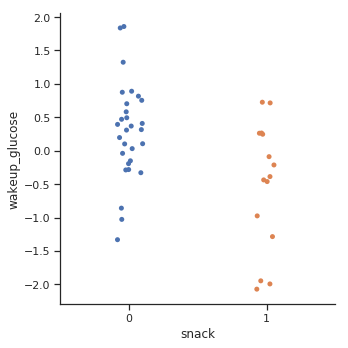

In [739]:
sns.catplot(x="snack", y="wakeup_glucose", data=cv_wakeup_snacks.loc['429763'])

In [686]:
night_cgm_stats = night_cgm_stats.reset_index()

In [728]:
night_cgm_stats.loc[(night_cgm_stats['RegistrationCode'] == '309076') &
                   (night_cgm_stats['CV'] > 0.3)]

,RegistrationCode,Day,mean,std,q50,q75,q90,q95,CV
6900,309076,2017-09-05,108.10119,50.804381,81.642857,112.392857,199.242857,205.242857,0.469971


In [730]:
vis_cgm('309076', datetime.date(2017,9,5))

In [736]:
logdf[(logdf['RegistrationCode'] == '309076') & (logdf['Date'].dt.date == datetime.date(2017,1,24))]
# logdf[(logdf['RegistrationCode'] == '309076')]

,RegistrationCode,Day,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type,alloc
54420,309076,2017-01-24,2017-01-24 13:10:45+02:00,0.0,320.360001,5.53209,2021.20741,45.85250,869.490196,11.908917,85.895008,0.39258,Meal,0
54421,309076,2017-01-24,2017-01-24 18:30:54+02:00,0.0,635.000000,4.97275,2075.99000,37.31505,481.326500,19.942665,16.235750,0.00000,Meal,0


In [726]:
# pbc for individuals:
for rc in cv_wakeup_snacks.index.unique():
    cv = cv_wakeup_snacks.loc[rc, 'CV']
    snacks = cv_wakeup_snacks.loc[rc, 'snack']
    pbc = pointbiserialr(cv, snacks)
    print(rc, pbc)

111527 PointbiserialrResult(correlation=0.23829985929490727, pvalue=0.008485345709793703)
126092 PointbiserialrResult(correlation=0.3864017010749692, pvalue=5.151557184644368e-06)
12752 PointbiserialrResult(correlation=0.33367046187560956, pvalue=0.003916064400032229)
130279 PointbiserialrResult(correlation=0.10158454018002132, pvalue=0.25769747366616147)
132095 PointbiserialrResult(correlation=0.138940511408124, pvalue=0.10284514059285259)
132178 PointbiserialrResult(correlation=0.24932511183018832, pvalue=0.002492958739345844)
133828 PointbiserialrResult(correlation=0.4081486849328624, pvalue=0.0017924553957776679)
136529 PointbiserialrResult(correlation=0.259749686820219, pvalue=0.004865695610762341)
139531 PointbiserialrResult(correlation=0.15386046081922256, pvalue=0.09199901620983911)
140050 PointbiserialrResult(correlation=0.10809370057288703, pvalue=0.4456032737556645)
142162 PointbiserialrResult(correlation=0.05759002218836562, pvalue=0.5653319656288083)
143892 PointbiserialrR

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



 PointbiserialrResult(correlation=0.08043412824199342, pvalue=0.40136041125952787)
501757 PointbiserialrResult(correlation=0.3384578758021176, pvalue=0.0008480561581754813)
509553 PointbiserialrResult(correlation=0.19424344429306664, pvalue=0.015782954834377066)
518788 PointbiserialrResult(correlation=0.1766094432593778, pvalue=0.033587784684836836)
525994 PointbiserialrResult(correlation=0.3370823072969029, pvalue=0.0002787506528654242)
533401 PointbiserialrResult(correlation=0.13191871927411689, pvalue=0.23162843881857473)
536037 PointbiserialrResult(correlation=0.06671565450371851, pvalue=0.6785519272637075)
54400 PointbiserialrResult(correlation=0.23105468740771806, pvalue=0.008426577666673242)
549830 PointbiserialrResult(correlation=0.03382956958979337, pvalue=0.7137603647687438)
550818 PointbiserialrResult(correlation=0.24686729093044465, pvalue=0.04401412189870855)
56031 PointbiserialrResult(correlation=0.18807803385540375, pvalue=0.06365681946300354)
563437 PointbiserialrResult

954295 PointbiserialrResult(correlation=0.37229614513190723, pvalue=8.501078131606644e-05)
954766 PointbiserialrResult(correlation=0.470475500139067, pvalue=9.591551248168942e-10)
963150 PointbiserialrResult(correlation=0.044608464328667774, pvalue=0.5941905629956614)
967551 PointbiserialrResult(correlation=0.21553919227705912, pvalue=0.019075447299402967)
972181 PointbiserialrResult(correlation=0.09799706113635233, pvalue=0.3554153734111674)
979162 PointbiserialrResult(correlation=-0.22118908402547363, pvalue=0.2879829997094361)
981727 PointbiserialrResult(correlation=0.2488021928700654, pvalue=0.01504544780998473)
988899 PointbiserialrResult(correlation=-0.25272068949465604, pvalue=0.1369962662798959)
992638 PointbiserialrResult(correlation=-0.011822270420624736, pvalue=0.8805704099756894)
997735 PointbiserialrResult(correlation=0.06111156877317507, pvalue=0.5001535235928491)


## Correlations between the food during the day and CV of the night